# [Zarr SODA 3.4.2 ds](https://www2.atmos.umd.edu/~ocean/index_files/soda3.4.2_mn_download_b.htm)

> https://www.soda.umd.edu/
>> https://www2.atmos.umd.edu/~ocean/index_files/soda3_readme.htm

>> https://www2.atmos.umd.edu/~ocean/index_files/soda3.3.1_mn_download.htm

>> https://dsrs.atmos.umd.edu/DATA/soda3.4.2/ORIGINAL/

In [1]:
! mamba install "xgcm<0.7.0" -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.25.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ["xgcm[version='<0.7.0']"]

conda-forge/linux-64                                        Using cache

In [2]:
import xgcm

In [3]:
xgcm.__version__

'0.6.1'

In [192]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [193]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.17614edc193f439b890ed59c2ee43548/status,


In [191]:
client.close()
cluster.close()

In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import json

In [5]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [6]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
url_transport = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_10dy_transport_or'
#url_ice = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ice_or'

fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)
transport = xr.open_zarr(fs.get_mapper(url_transport), consolidated=True)
#ice = xr.open_zarr(fs.get_mapper(url_ice), consolidated=True)

In [8]:
#fix time dim (1896/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [9]:
import xgcm

grid_ocean = xgcm.Grid(ocean, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

In [70]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center

## Variables to create:

- [ ] Vel terms for psi
- [ ] Surf flux term (incl. sw penetration)
- [ ] Total tendency term

## <font color='Green'>Get cell area and volume in meters</font>

In [15]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [17]:
#converting lat from degrees to meters
delta_lat = grid_ocean.diff(ocean.yt_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree
delta_lat_u = grid_ocean.diff(ocean.yu_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy_u = delta_lat_u * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid_ocean.diff(ocean.xt_ocean, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ocean.yt_ocean))
delta_lon_u = grid_ocean.diff(ocean.xu_ocean, 'X', boundary_discontinuity=360)
dx_u = delta_lon_u * meters_per_degree * np.cos(np.deg2rad(ocean.yu_ocean))

In [18]:
from xgcm.autogenerate import generate_grid_ds

# download the data
import urllib.request
import shutil

url = 'https://zenodo.org/record/4421428/files/'
file_name = 'uvwnd.10m.gauss.2018.nc'
with urllib.request.urlopen(url + file_name) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# open the data
ds = xr.open_dataset(file_name)
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})

grid = xgcm.Grid(ds_full, periodic=['X'])
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center
T Axis (not periodic, boundary=None):
  * center   time
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center

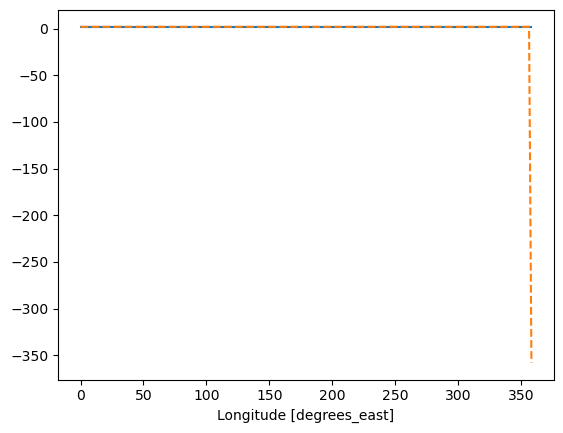

In [19]:
dlong = grid.diff(ds_full.lon, 'X', boundary_discontinuity=360)
dlonc = grid.diff(ds_full.lon_left, 'X', boundary_discontinuity=360)
dlonc_wo_discontinuity = grid.diff(ds_full.lon_left, 'X')

dlatg = grid.diff(ds_full.lat, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.lat_left, 'Y', boundary='fill', fill_value=np.nan)

dlonc.plot()
dlonc_wo_discontinuity.plot(linestyle='--')

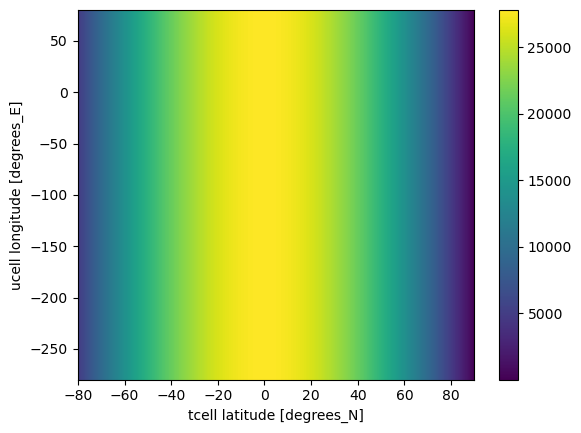

In [20]:
dx.plot()

In [21]:
dz = grid_ocean.diff(ocean.st_edges_ocean[1:], 'Z', boundary='fill', fill_value=0.)
dz_u = grid_ocean.diff(ocean.sw_edges_ocean[1:], 'Zu', boundary='fill', fill_value=0.)

In [22]:
cell_elements = xr.merge([dx.rename('dx'), dx_u.rename('dx_u'), 
                          dy.rename('dy'), dy_u.rename('dy_u'), 
                          dz.rename('dz'), dz_u.rename('dz_u')])

In [23]:
cell_elements

<xarray.Dataset>
Dimensions:   (xu_ocean: 1440, yt_ocean: 1070, xt_ocean: 1440, yu_ocean: 1070,
               st_ocean: 50, sw_ocean: 50)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.74 89.84 89.95
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... 89.79 89.89 90.0
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_ocean  (sw_ocean) float64 10.07 20.16 30.29 ... 5.08e+03 5.29e+03 5.5e+03
Data variables:
    dx        (xu_ocean, yt_ocean) float64 4.817e+03 4.868e+03 ... 76.81 25.58
    dx_u      (xt_ocean, yu_ocean) float64 4.842e+03 4.893e+03 ... 1.702e-12
    dy        (yu_ocean) float64 1.174e+04 1.174e+04 1.174e+04 ... 1.174e+04 nan
    dy_u      (yt_ocean) float64 nan 1.174e+04 1.174e+04 ... 1.174e+04 1.173e+04
    dz        (st_ocean) float64 10.09 10.13 10.18 ... 209.9 209.9 -5.5e+03
    dz_u      (sw_ocean) float64 10.12 10.14 10.22 ... 209.9 105.0 -5.5e+03

## <font color='Green'>Slice to WG region</font>

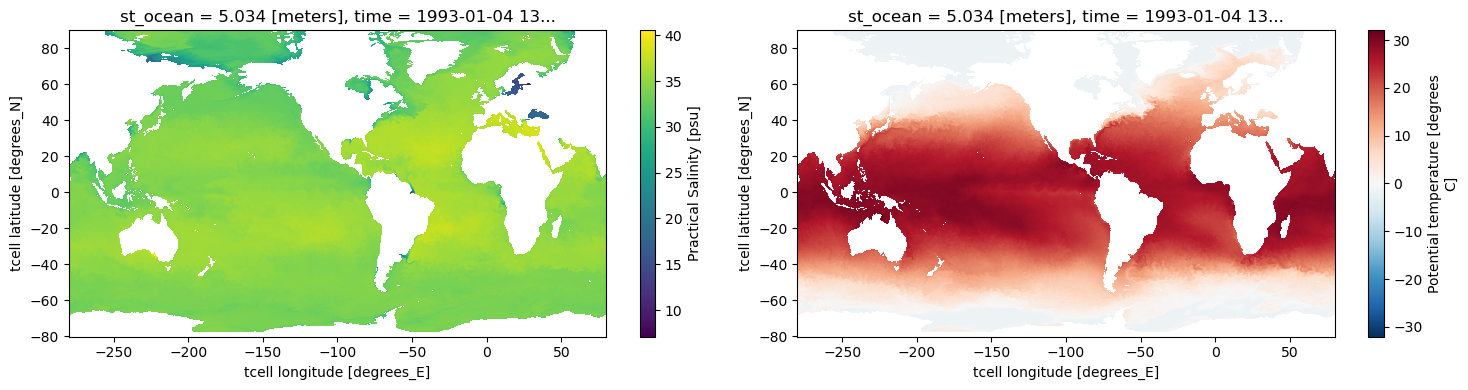

In [26]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
ocean.salt[0,0].plot(ax=ax0)
ocean.temp[0,0].plot(ax=ax1)
plt.tight_layout();

In [45]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 208 #-57.08962246
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 208 #-57.02158171
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [46]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [71]:
ocean_wg = ocean.isel(**lat_range, **lon_range)
transport_wg = transport.isel(**lat_range, **lon_range)
cells_wg = cell_elements.isel(**lat_range, **lon_range)

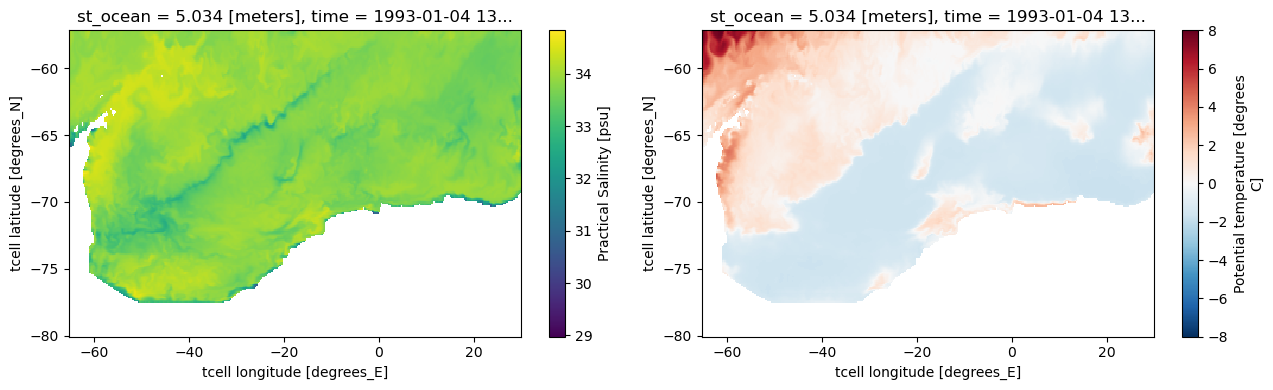

In [49]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(13,4))
ocean_wg.salt[0,0].plot(ax=ax0)
ocean_wg.temp[0,0].plot(ax=ax1)
plt.tight_layout();

In [72]:
grid_ocean_wg = xgcm.Grid(ocean_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean_wg

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

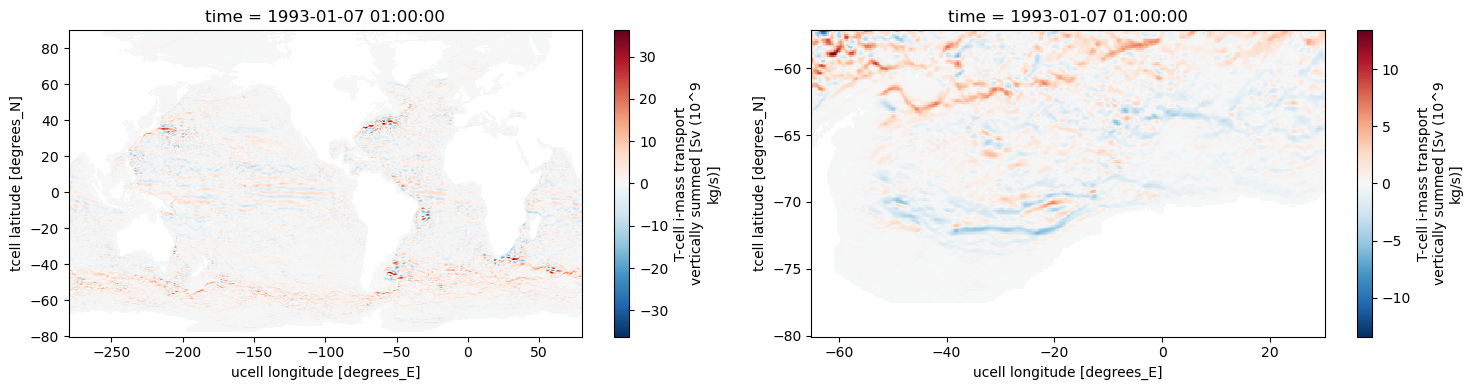

In [73]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
transport.tx_int[0].plot(ax=ax0)
transport_wg.tx_int[0].plot(ax=ax1)
plt.tight_layout();

## <font color='Green'>\begin{equation*} Transport/Vel\ terms \end{equation*}</font>

In [79]:
u_transport_right = (transport_wg.tx_trans * cells_wg.dz * cells_wg.dy_u).isel(xu_ocean=-1)
u_transport_left = (transport_wg.tx_trans * cells_wg.dz * cells_wg.dy_u).isel(xu_ocean=0)

v_transport = (transport_wg.ty_trans * cells_wg.dz * cells_wg.dx_u).isel(yu_ocean=-1)

In [80]:
dx_interp = grid_ocean_wg.interp(cells_wg.dx_u, 'Y', boundary='fill')

In [81]:
w_transport = (ocean_wg.wt * dx_interp * cells_wg.dy_u).isel(sw_ocean=0)

In [82]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3 #rho

#surf_transport = (ocean_wg.net_heating * dx_interp * cells_wg.dy_u) / (heat_capacity_cp * runit2mass)
surf_transport = ocean_wg.net_heating  / (heat_capacity_cp * runit2mass)

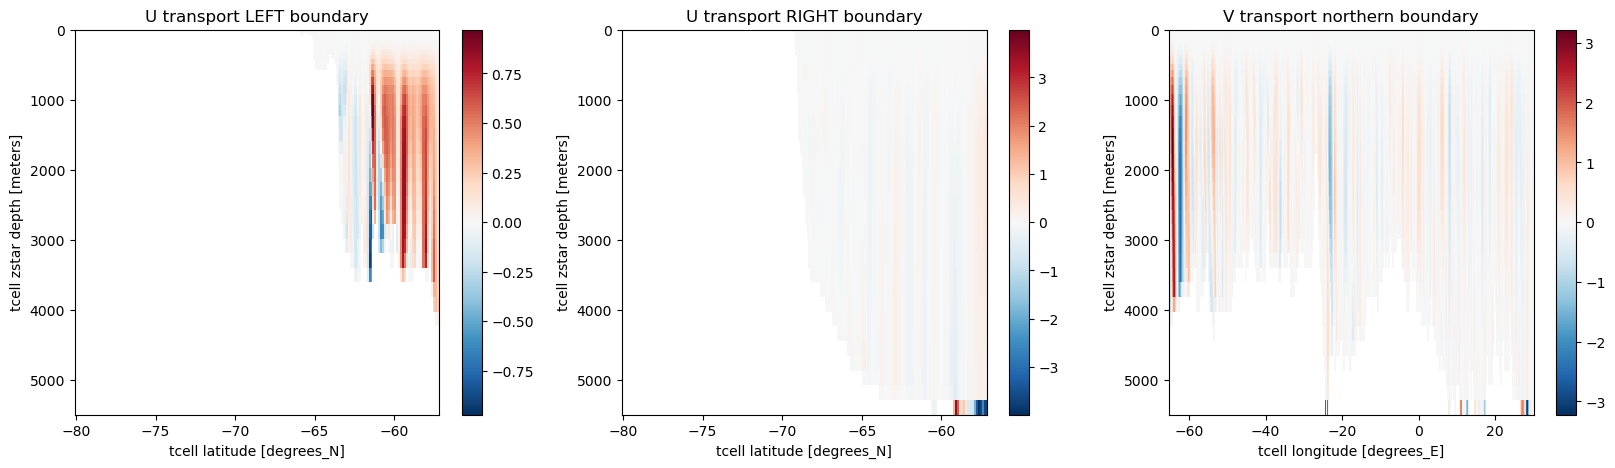

In [84]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

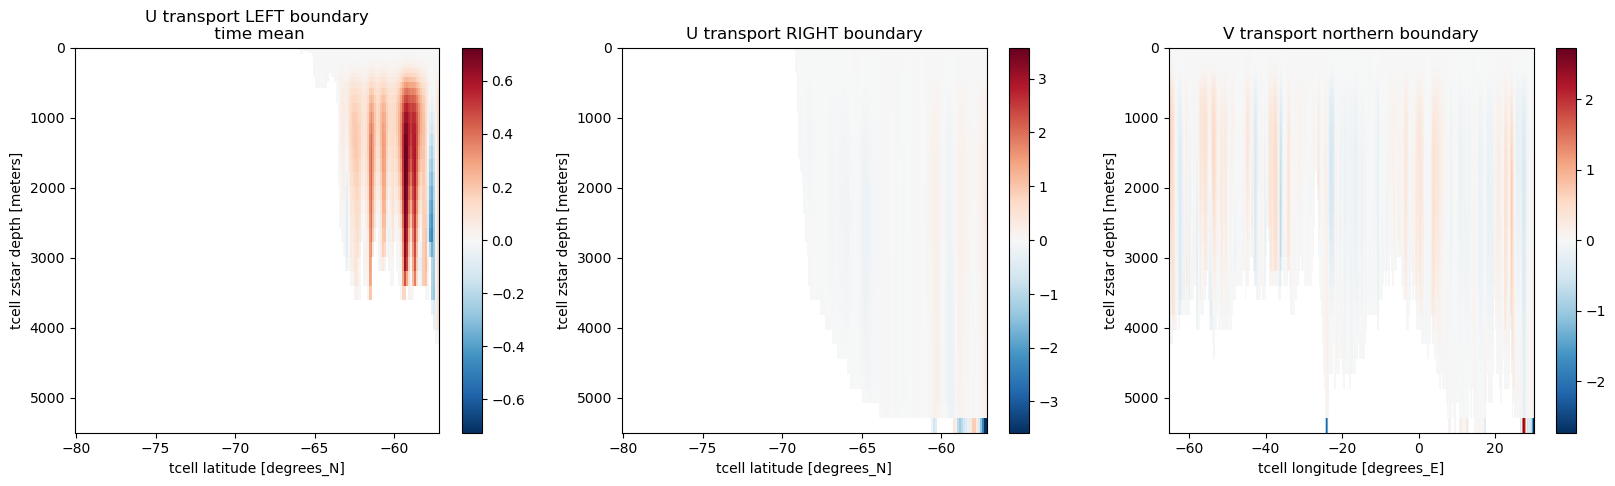

In [86]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left.mean(dim='time')/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary\n time mean')
(u_transport_right.mean(dim='time')/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport.mean(dim='time')/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [87]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.a02654870ff54c78a0995ccbdf8f2c0c/status,


In [93]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean', 'st_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean', 'st_ocean'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-170.07954714)

In [94]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean', 'st_ocean']).mean(dim='time')/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(174.50682106)
Coordinates:
    yu_ocean  float64 -57.16

In [95]:
w_transport_mean_value = (w_transport).fillna(0.).sum(dim=['xt_ocean', 'yt_ocean']).mean(dim='time')/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(1.73622805)
Coordinates:
    sw_ocean  float64 10.07

In [96]:
surf_transport_mean_value = surf_transport.fillna(0.).sum(dim=['xt_ocean', 'yt_ocean']).mean(dim='time')
surf_transport_mean_value.load()

<xarray.DataArray 'net_heating' ()>
array(-0.20475842, dtype=float32)

In [97]:
residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
residual

<xarray.DataArray ()>
array(4.42727392)
Coordinates:
    yu_ocean  float64 -57.16

## <font color='Green'>\begin{equation*} Surface\ Fluxes \end{equation*}</font>

In [102]:
heat_capacity_cp = 3.994e3 #J/kg/˚C
runit2mass = 1.035e3 #rho

surf_flux_th = (ocean_wg.hflux_total * dx_interp * cells_wg.dy_u) / (heat_capacity_cp * runit2mass) #˚C*m^3/s
surf_flux_slt = (ocean_wg.salt_flux_total * 1000 * dx_interp * cells_wg.dy_u) / runit2mass # psu*m^3/s

In [109]:
def surface_to_3d(da):
    da = da.copy()
    da.coords['st_ocean'] = ocean_wg.st_ocean[0]
    da = da.expand_dims(dim='st_ocean', axis=1)
    da, _ = xr.align(da, ocean_wg.st_ocean, join='right')
    return da.fillna(0.)

In [110]:
surf_flux_conv_TH = surface_to_3d(surf_flux_th)
surf_flux_conv_SLT = surface_to_3d(surf_flux_slt)

## SW flux penetration

In [111]:
#sw flux
sw_flux = (ocean_wg.swflx * dx_interp * cells_wg.dy_u) / (heat_capacity_cp * runit2mass) #˚C*m^3/s

In [112]:
coords = ocean_wg.coords.to_dataset().reset_coords()

In [113]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""
    
    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]
    
    facz = - fact * coords.st_edges_ocean.sel(st_edges_ocean=slice(0, 215))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))
            
    return swdk.rename('swdk')

_, swdown = xr.align(ocean_wg.st_edges_ocean, sw_flux * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

In [114]:
#convergence of swdown
sw_flux_conv_TH = -grid_ocean_wg.diff(swdown[:,:,:,:-1], 'Z', boundary='fill')
sw_flux_conv_TH

,Array,Chunk
Bytes,58.16 GiB,29.63 MiB
Shape,"(1970, 208, 381, 50)","(1, 208, 381, 49)"
Count,36 Graph Layers,3940 Chunks
Type,float64,numpy.ndarray


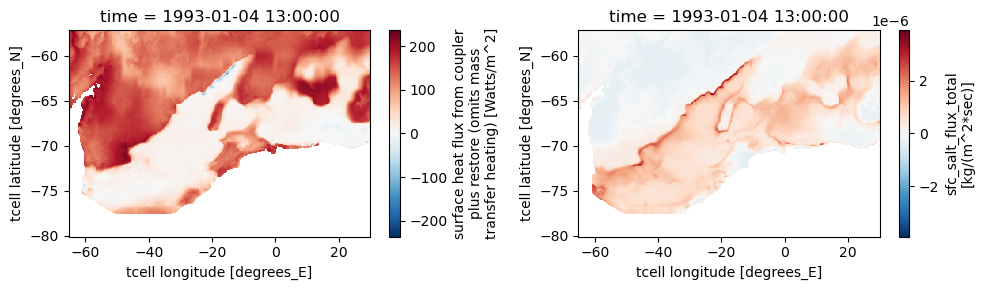

In [104]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
ocean_wg.hflux_total[0].plot(ax=ax0)
ocean_wg.salt_flux_total[0].plot(ax=ax1)
plt.tight_layout();

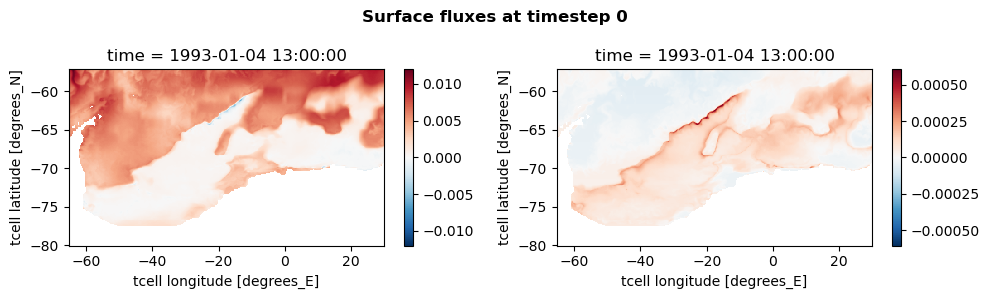

In [105]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th[0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt[0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Surface fluxes at timestep 0', fontweight='bold')
plt.tight_layout();

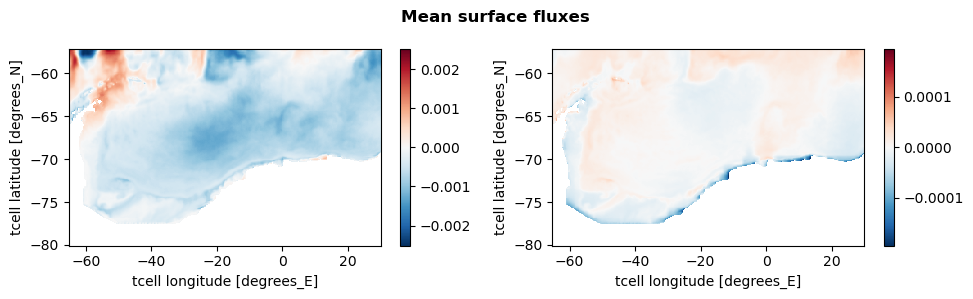

In [106]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

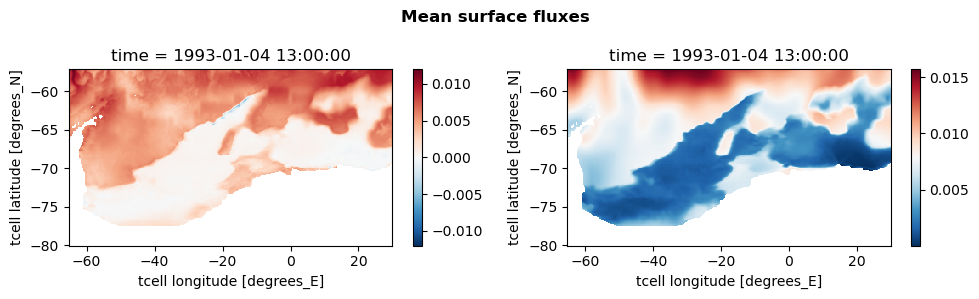

In [115]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6)[0].plot(cmap='RdBu_r', ax=ax0)
(sw_flux/1e6)[0].plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

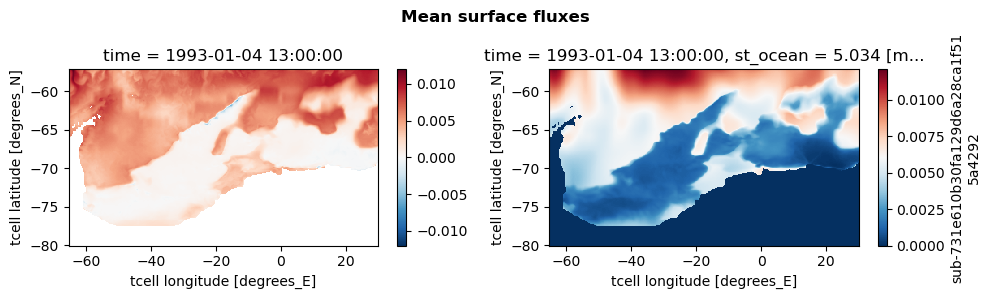

In [116]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6)[0].plot(cmap='RdBu_r', ax=ax0)
(sw_flux_conv_TH/1e6)[0, :, :, 0].plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

## <font color='Green'>\begin{equation*} Total\ Tendency \end{equation*}</font>

In [117]:
dt_values = (ocean_wg.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], ocean_wg.time.values[1:])}) #shaves off first time stamp in `ocean_wg.time_no1980`
ocean_wg.coords['dt'] = dt


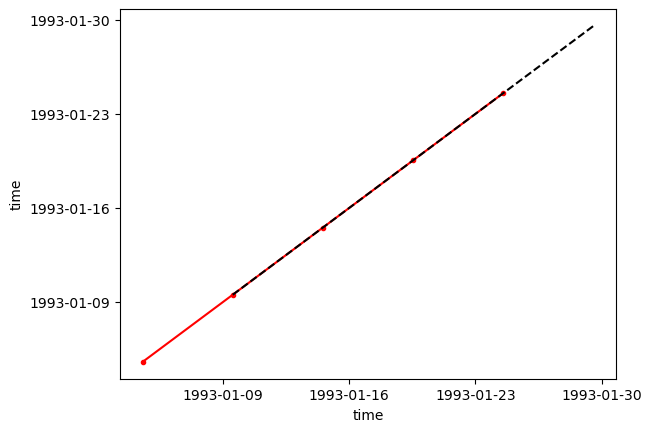

In [119]:
ocean_wg.time[0:5].plot(color='r', marker='.')
dt_values.time[0:5].plot(color='k', linestyle='dashed')

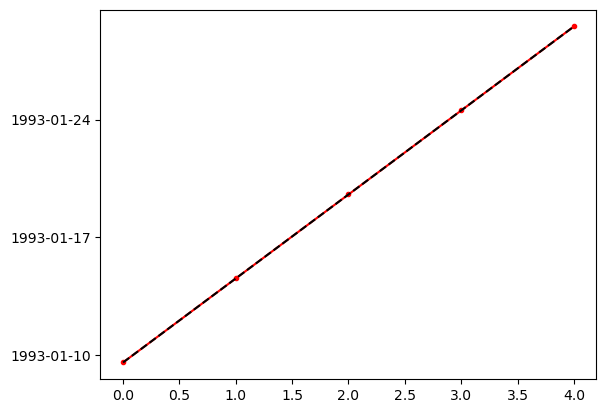

In [121]:
plt.plot(ocean_wg.time.values[1:6], color='r', marker='.')
plt.plot(dt.time.values[0:5], color='k', linestyle='dashed')

**Theta Tendency Term**

In [122]:
delta_theta = ocean_wg.temp.diff('time')#.load()

In [124]:
#forcing delta_theta to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','st_ocean','yt_ocean','xt_ocean'], 
                            coords={'time': ocean_wg.dt[1:].time.data,
                                    'st_ocean': ocean_wg.st_ocean,
                                    'yt_ocean': ocean_wg.yt_ocean,
                                    'xt_ocean': ocean_wg.xt_ocean})
delta_theta

,Array,Chunk
Bytes,29.06 GiB,15.12 MiB
Shape,"(1969, 50, 208, 381)","(1, 50, 208, 381)"
Count,6 Graph Layers,1969 Chunks
Type,float32,numpy.ndarray


In [125]:
theta_tend = (delta_theta / ocean_wg.dt)#.load()

In [126]:
theta_tend

,Array,Chunk
Bytes,29.06 GiB,15.12 MiB
Shape,"(1969, 50, 208, 381)","(1, 50, 208, 381)"
Count,9 Graph Layers,1969 Chunks
Type,float32,numpy.ndarray


In [129]:
totttend = theta_tend * dx_interp * cells_wg.dy_u * cells_wg.dz

**Salt Tendency Term**

In [130]:
delta_salt = ocean_wg.salt.diff('time')

In [131]:
#forcing delta_salt to have same timestamp as ds.dt by creating new data array called "salt_scaled"
delta_salt = xr.DataArray(delta_salt.data, dims=['time','st_ocean','yt_ocean','xt_ocean'], 
                            coords={'time': ocean_wg.dt[1:].time.data,
                                    'st_ocean': ocean_wg.st_ocean,
                                    'yt_ocean': ocean_wg.yt_ocean,
                                    'xt_ocean': ocean_wg.xt_ocean})
delta_salt

,Array,Chunk
Bytes,29.06 GiB,15.12 MiB
Shape,"(1969, 50, 208, 381)","(1, 50, 208, 381)"
Count,6 Graph Layers,1969 Chunks
Type,float32,numpy.ndarray


In [132]:
salt_tend = (delta_salt / ocean_wg.dt)

In [133]:
totstend = salt_tend * dx_interp * cells_wg.dy_u * cells_wg.dz

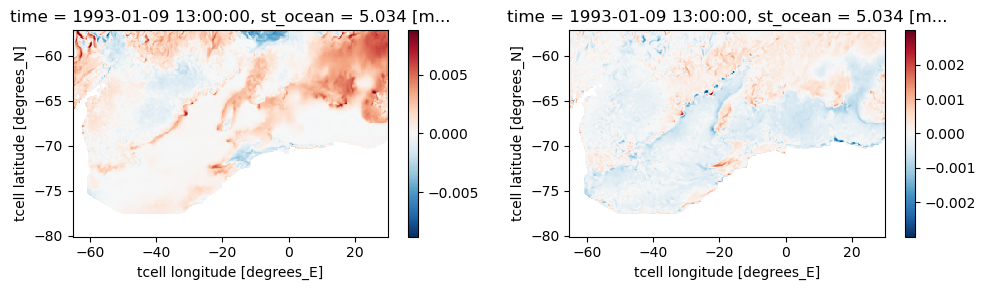

In [134]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(totstend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

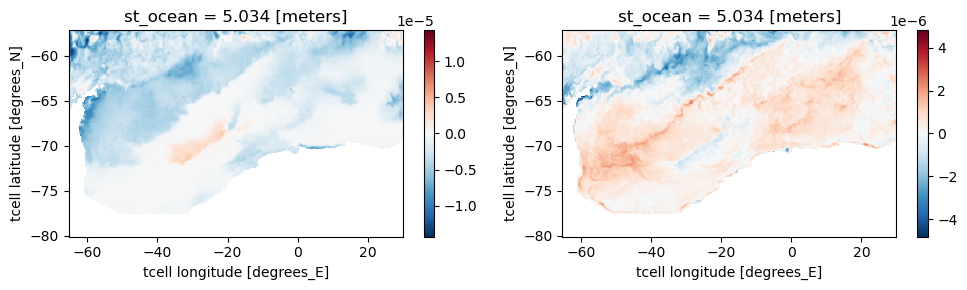

In [135]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend.isel(time=slice(0,-1), st_ocean=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(totstend.isel(time=slice(0,-1), st_ocean=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

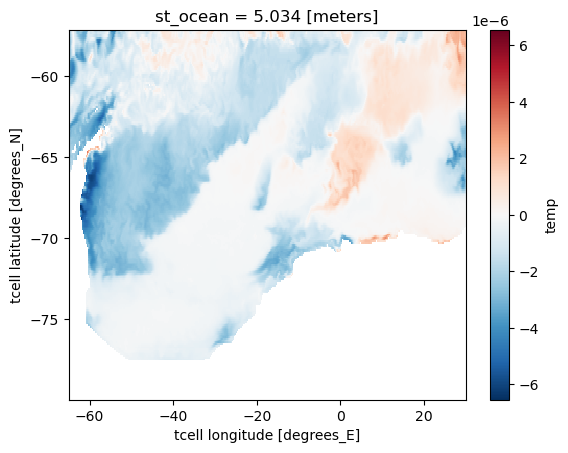

In [136]:
#last jan minus first jan
((ocean_wg.temp[-71,0, 1:, 1:] - ocean_wg.temp[0,0, 1:, 1:])/1e6).plot(cmap='RdBu_r')#, vmax=0)#, vmin=-6e-5)

### Updating northern boundary to be from 62˚S to 57˚S

In [18]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat_old = 169 #-62.01972704
upper_lat = 208 #225:-54.70774816 #208:-57.08962246
left_lon =  859 #-65.12
right_lon_old = 1240 #30.12
right_lon = 1200 #20.125

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [19]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_no_u_old = dict(yt_ocean=slice(lower_lat, upper_lat_old))
lon_range_no_u_old = dict(xt_ocean=slice(left_lon, right_lon_old))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

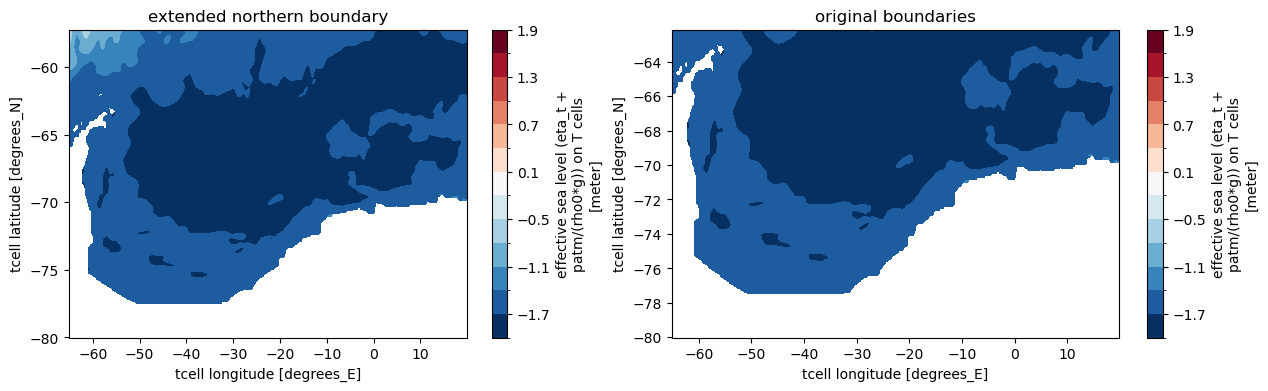

In [20]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4), gridspec_kw={'width_ratios': [2.4,2.7]})
ocean.ssh.isel(**lat_range_no_u, **lon_range_no_u)[0].plot.contourf(levels=np.arange(-2,2,0.3), ax=ax0)
ocean.ssh.isel(**lat_range_no_u_old, **lon_range_no_u)[0].plot.contourf(levels=np.arange(-2,2,0.3), ax=ax1)

ax0.set_title('extended northern boundary')
ax1.set_title('original boundaries');

## Saving Data

In [139]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [205]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.17614edc193f439b890ed59c2ee43548/status,


In [208]:
transport_drop = transport_wg.drop_dims('nv')

In [209]:
#saving transport terms in wg region
gcfs_transport_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/transport_wg.zarr')
transport_drop.to_zarr(gcfs_transport_wg, mode='w')

In [146]:
cells_wg['dx_interp'] = dx_interp

In [149]:
#saving cell elements in wg region
gcfs_cells_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/cells_wg.zarr')
cells_wg.to_zarr(gcfs_cells_wg, mode='w')

In [150]:
surf_terms = xr.merge([surf_flux_conv_SLT.rename('surf_flux_conv_SLT'),
                       surf_flux_conv_TH.rename('surf_flux_conv_TH'),
                       sw_flux_conv_TH.rename('sw_flux_conv_TH')])

In [151]:
surf_terms = surf_terms.chunk({'st_ocean':50})

In [153]:
surf_terms

,Array,Chunk
Bytes,58.16 GiB,30.23 MiB
Shape,"(1970, 50, 208, 381)","(1, 50, 208, 381)"
Count,28 Graph Layers,1970 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,58.16 GiB,30.23 MiB
Shape,"(1970, 50, 208, 381)","(1, 50, 208, 381)"
Count,27 Graph Layers,1970 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [157]:
gcfs_surf_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/surf_terms.zarr')
surf_terms.chunk({'st_ocean':50}).to_zarr(gcfs_surf_terms, mode='w')

In [154]:
totend = xr.merge([totttend.rename('totttend'),
                   totstend.rename('totstend')])

In [158]:
gcfs_totend = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/totend.zarr')
totend.to_zarr(gcfs_totend, mode='w')

In [277]:
client.close()
cluster.close()